In [5]:
import pandas as pd
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t, shapiro
import warnings
from scipy.stats import iqr
from sklearn.utils import resample

In [6]:


# Load the Excel file
file_path = "allinone_adjusted_final.xlsx"
df = pd.read_excel(file_path)

# Normalize column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Choose the correct price column
price_col = 'price_hub' if 'price_hub' in df.columns else 'price'

# Group by hubs
grouped = df.groupby('hubs')[price_col]

# Compute all required statistics
summary = pd.DataFrame({
    'Mean': grouped.mean(),
    'Standard Deviation': grouped.std(),
    'Maximum': grouped.max(),
    'Minimum': grouped.min(),
    'Skewness': grouped.apply(lambda x: skew(x.dropna())),
    'Kurtosis': grouped.apply(lambda x: kurtosis(x.dropna())),
    #'IQR': grouped.apply(lambda x: x.dropna().quantile(0.75) - x.dropna().quantile(0.25))
}).reset_index()

# Print or export
print(summary)

# Optional: save to Excel
# summary.to_excel("hub_statistics_with_iqr.xlsx", index=False)


                      hubs       Mean  Standard Deviation  Maximum    Minimum  \
0                  Indiana  39.654756           16.714653   200.00  17.916257   
1                    Mid C  42.292554           45.508711   583.04  -0.444795   
2          Palo Verde Peak  45.226257           64.917091  1639.60   0.000000   
3  SP15 EZ Gen DA LMP Peak  49.543732           42.451844   595.09   0.000000   

    Skewness    Kurtosis  
0   4.039098   24.611112  
1   5.336777   43.817460  
2  12.744934  236.263163  
3   5.343232   40.984599  


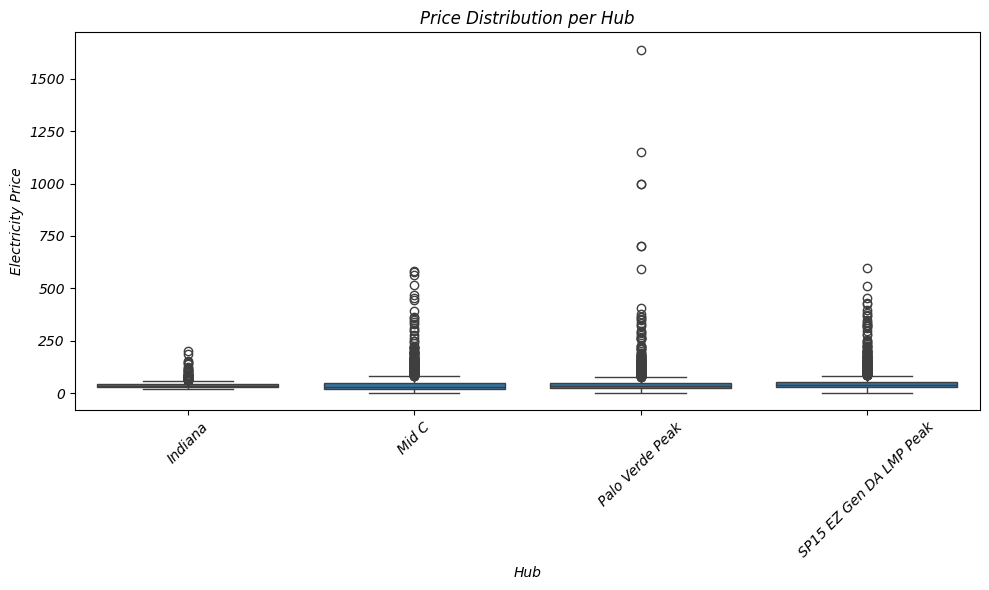

In [7]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='hubs', y=price_col, data=df)
plt.title("Price Distribution per Hub")
plt.ylabel("Electricity Price")
plt.xlabel("Hub")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


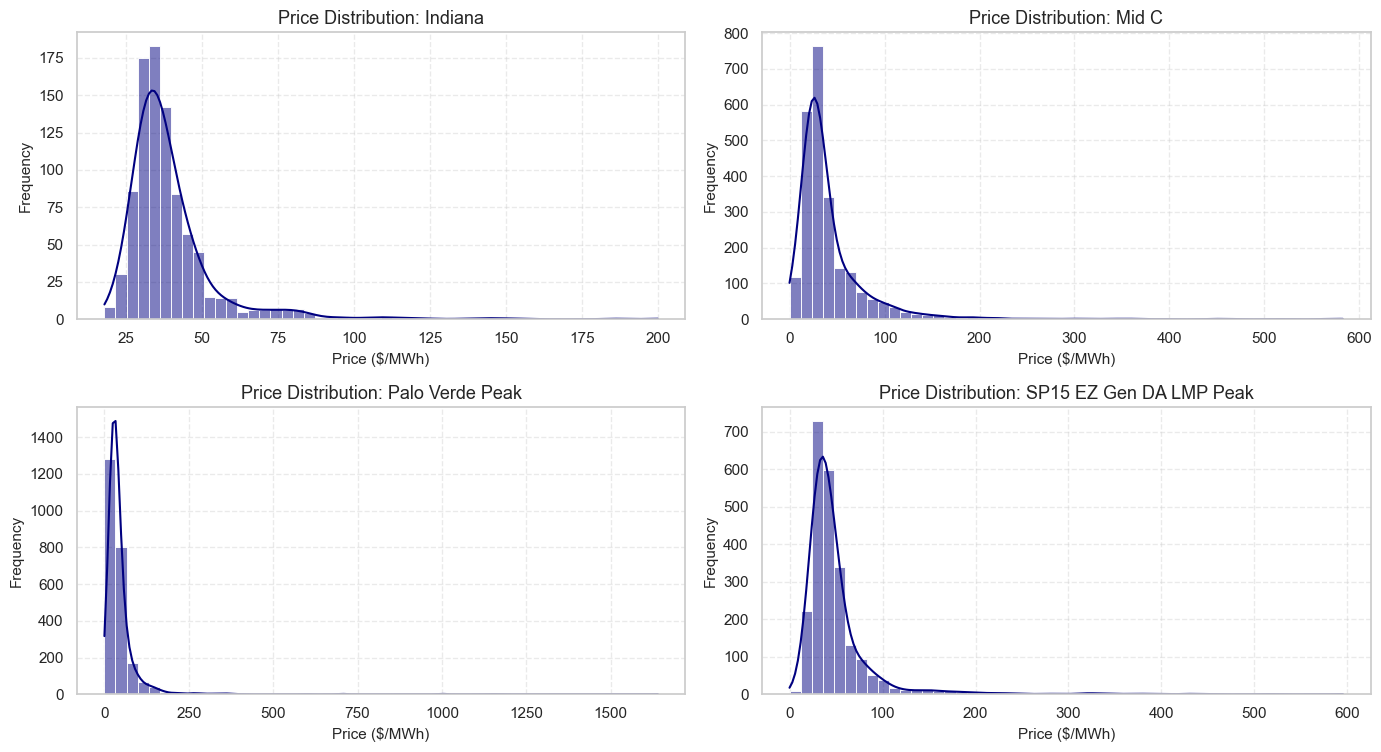

In [8]:


#Load Excel file
file_path = "allinone_adjusted_final.xlsx"
df = pd.read_excel(file_path)

#Normalize column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

#Determine which price column to use
price_col = 'price_hub' if 'price_hub' in df.columns else 'price'

#Set seaborn style
sns.set(style="whitegrid", context="notebook")

#Get unique hubs
unique_hubs = df['hubs'].unique()
num_hubs = len(unique_hubs)

#Create subplot grid
cols = 2
rows = (num_hubs + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
axes = axes.flatten()

#Plot histogram + KDE for each hub
for i, hub in enumerate(unique_hubs):
    ax = axes[i]
    data = df[df['hubs'] == hub][price_col]
    sns.histplot(data, kde=True, bins=50, ax=ax, color='navy')
    ax.set_title(f"Price Distribution: {hub}", fontsize=13)
    ax.set_xlabel("Price ($/MWh)", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.4)

#Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#Set global title and layout
#fig.suptitle("Electricity Price Distributions by Hub", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [9]:
#Create folder if it doesn't exist
import os

save_dir = "figures"
os.makedirs(save_dir, exist_ok=True)

#Save the figure before showing
fig_path = os.path.join(save_dir, "price_distributions_by_hub.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')  # High quality

#Show the figure
plt.show()


<Figure size 640x480 with 0 Axes>

In [10]:

#Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

#Load Excel and normalize columns
df = pd.read_excel("allinone_adjusted_final.xlsx")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
price_col = 'price_hub' if 'price_hub' in df.columns else 'price'

#Confidence Interval function
def compute_ci(series, confidence=0.95):
    n = series.dropna().shape[0]
    m = np.mean(series)
    se = sem(series, nan_policy='omit')
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return m - h, m + h

# Loop through hubs and collect results
results = []

for hub, group in df.groupby('hubs'):
    prices = group[price_col].dropna()
    ci_lower, ci_upper = compute_ci(prices)
    stat, p = shapiro(prices if len(prices) <= 5000 else prices.sample(5000))  # Shapiro-Wilk test (sample if large)
    results.append({
        "Hub": hub,
        "Mean": prices.mean(),
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
        "Shapiro-Wilk p-value": p,
        "Is Normal (p > 0.05)": p > 0.05
    })

#Convert to DataFrame
ci_df = pd.DataFrame(results)

#Print the final table
print(ci_df)


                       Hub       Mean  95% CI Lower  95% CI Upper  \
0                  Indiana  39.654756     38.567920     40.741593   
1                    Mid C  42.292554     40.472459     44.112650   
2          Palo Verde Peak  45.226257     42.629394     47.823121   
3  SP15 EZ Gen DA LMP Peak  49.543732     47.816517     51.270948   

   Shapiro-Wilk p-value  Is Normal (p > 0.05)  
0          1.439751e-39                 False  
1          4.923388e-61                 False  
2          1.992912e-69                 False  
3          2.518090e-61                 False  


In [11]:

# Load Excel file
df = pd.read_excel("allinone_adjusted_final.xlsx")  # Update path if needed

# Normalize column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Choose the correct price column
price_col = 'price_hub' if 'price_hub' in df.columns else 'price'

# Parameters
n_bootstrap = 1000
confidence = 0.95

# Function to compute bootstrapped CI for median
def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    medians = []
    for _ in range(n_bootstrap):
        sample = resample(data, replace=True)
        medians.append(np.median(sample))
    lower = np.percentile(medians, (1 - ci) / 2 * 100)
    upper = np.percentile(medians, (1 + ci) / 2 * 100)
    return lower, upper

# Calculate robust statistics per hub
robust_stats = []
for hub, group in df.groupby('hubs'):
    prices = group[price_col].dropna()
    median_val = np.median(prices)
    iqr_val = iqr(prices)
    ci_lower, ci_upper = bootstrap_ci(prices)
    robust_stats.append({
        "Hub": hub,
        "Median": median_val,
        "IQR": iqr_val,
        "Bootstrapped Median CI Lower": ci_lower,
        "Bootstrapped Median CI Upper": ci_upper
    })

#Create DataFrame
robust_df = pd.DataFrame(robust_stats)

#Display the result
print(robust_df)

# Optional: Save to Excel
# robust_df.to_excel("robust_statistics_summary.xlsx", index=False)


                       Hub  Median     IQR  Bootstrapped Median CI Lower  \
0                  Indiana  35.620  11.405                         35.12   
1                    Mid C  29.155  24.505                         28.46   
2          Palo Verde Peak  31.270  21.355                         30.42   
3  SP15 EZ Gen DA LMP Peak  38.860  21.310                         38.11   

   Bootstrapped Median CI Upper  
0                      36.17025  
1                      29.95000  
2                      32.21000  
3                      39.52050  
